## Part 1: Contouring time assesment

In [1]:
#Loading libraries
import numpy as np
import pandas as pd
import SimpleITK as sitk
import seaborn as sns
import operator as op
import matplotlib.patches as mpatches
import os,re
import scipy
import matplotlib.pyplot as plt
import warnings

from statannot import add_stat_annotation
from scipy import ndimage
from tqdm.notebook import tqdm 


#ignore some depr warnings
warnings.filterwarnings("ignore")



C:\Users\s.primakov\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\s.primakov\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\s.primakov\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
In C:\Users\s.primakov\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\s.primakov\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\s.primakov\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the '

In [2]:
#Initializing Metrics
import lookup_tables

def dice_metric(y_true, y_pred,null_div = 0 ):
    ''' Compute soerensen-dice coefficient between two arrays y_true and y_pred
    Args: y_true: n-dim numpy array of type bool
    y_pred: n-dim numpy array of type bool
    Return: Dice similiarity coeff. type float, in case of division by zero returns null_div variable '''
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    denom = np.sum(y_true_f) + np.sum(y_pred_f)
    if denom !=0:
        return 2. * intersection/ denom
    else:
        return null_div
    
def jaccard_metric(y_true, y_pred,null_div = 0 ):
    ''' Compute Jaccard IOU coefficient between two arrays y_true and y_pred
    Args: y_true: n-dim numpy array of type bool
    y_pred: n-dim numpy array of type bool
    Return: Jaccard metric, type float, in case of division by zero returns null_div variable '''
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(1*((y_true_f+y_pred_f)>0))
    if union !=0:
        return 1. * intersection/ union
    else:
        return null_div

def compute_hausdorf_surf_distance(mask_gt, mask_pred, spacing_mm, percent=95):
    """Computes the robust Hausdorff distance. "Robust", because it uses the `percent` percentile 
    of the distances instead of the maximum distance. The percentage is computed by correctly taking 
    the area of each surface element into account.
    Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.
    spacing_mm: 3-element list-like structure. Voxel spacing in x0, x1 and x2 direction.
    percent: a float value between 0 and 100.
    Returns:
    a float value. The robust Hausdorff distance in mm. If one of the masks
    is empty, the corresponding lists are empty and all distances in the other
    list are `inf`.
    """

    # compute the area for all 256 possible surface elements
    # (given a 2x2x2 neighbourhood) according to the spacing_mm
    neighbour_code_to_surface_area = np.zeros([256])
    for code in range(256):
        normals = np.array(lookup_tables.neighbour_code_to_normals[code])
        sum_area = 0
        for normal_idx in range(normals.shape[0]):
            # normal vector
            n = np.zeros([3])
            n[0] = normals[normal_idx, 0] * spacing_mm[1] * spacing_mm[2]
            n[1] = normals[normal_idx, 1] * spacing_mm[0] * spacing_mm[2]
            n[2] = normals[normal_idx, 2] * spacing_mm[0] * spacing_mm[1]
            area = np.linalg.norm(n)
            sum_area += area
        neighbour_code_to_surface_area[code] = sum_area

    # compute the bounding box of the masks to trim
    # the volume to the smallest possible processing subvolume
    mask_all = mask_gt | mask_pred
    bbox_min = np.zeros(3, np.int64)
    bbox_max = np.zeros(3, np.int64)

    # max projection to the x0-axis
    proj_0 = np.max(np.max(mask_all, axis=2), axis=1)
    idx_nonzero_0 = np.nonzero(proj_0)[0]
    if len(idx_nonzero_0) == 0:  # pylint: disable=g-explicit-length-test
        return {"distances_gt_to_pred": np.array([]),
                "distances_pred_to_gt": np.array([]),
                "surfel_areas_gt": np.array([]),
                "surfel_areas_pred": np.array([])}

    bbox_min[0] = np.min(idx_nonzero_0)
    bbox_max[0] = np.max(idx_nonzero_0)

    # max projection to the x1-axis
    proj_1 = np.max(np.max(mask_all, axis=2), axis=0)
    idx_nonzero_1 = np.nonzero(proj_1)[0]
    bbox_min[1] = np.min(idx_nonzero_1)
    bbox_max[1] = np.max(idx_nonzero_1)

    # max projection to the x2-axis
    proj_2 = np.max(np.max(mask_all, axis=1), axis=0)
    idx_nonzero_2 = np.nonzero(proj_2)[0]
    bbox_min[2] = np.min(idx_nonzero_2)
    bbox_max[2] = np.max(idx_nonzero_2)

    # crop the processing subvolume.
    # we need to zeropad the cropped region with 1 voxel at the lower,
    # the right and the back side. This is required to obtain the "full"
    # convolution result with the 2x2x2 kernel
    cropmask_gt = np.zeros((bbox_max - bbox_min)+2, np.uint8)
    cropmask_pred = np.zeros((bbox_max - bbox_min)+2, np.uint8)

    cropmask_gt[0:-1, 0:-1, 0:-1] = mask_gt[bbox_min[0]:bbox_max[0]+1,bbox_min[1]:bbox_max[1]+1,
                                          bbox_min[2]:bbox_max[2]+1]

    cropmask_pred[0:-1, 0:-1, 0:-1] = mask_pred[bbox_min[0]:bbox_max[0]+1,bbox_min[1]:bbox_max[1]+1,
                                              bbox_min[2]:bbox_max[2]+1]

    # compute the neighbour code (local binary pattern) for each voxel
    # the resultsing arrays are spacially shifted by minus half a voxel in each
    # axis.
    # i.e. the points are located at the corners of the original voxels
    kernel = np.array([[[128, 64],[32, 16]],[[8, 4],[2, 1]]])
    
    neighbour_code_map_gt = ndimage.filters.correlate(cropmask_gt.astype(np.uint8), kernel, mode="constant", cval=0)
    neighbour_code_map_pred = ndimage.filters.correlate(cropmask_pred.astype(np.uint8), kernel, mode="constant", cval=0)

    # create masks with the surface voxels
    borders_gt = ((neighbour_code_map_gt != 0) & (neighbour_code_map_gt != 255))
    borders_pred = ((neighbour_code_map_pred != 0) &(neighbour_code_map_pred != 255))

    # compute the distance transform (closest distance of each voxel to the surface voxels)
    if borders_gt.any():
        distmap_gt = ndimage.morphology.distance_transform_edt(~borders_gt, sampling=spacing_mm)
    else:
        distmap_gt = np.Inf * np.ones(borders_gt.shape)

    if borders_pred.any():
        distmap_pred = ndimage.morphology.distance_transform_edt(~borders_pred, sampling=spacing_mm)
    else:
        distmap_pred = np.Inf * np.ones(borders_pred.shape)

    # compute the area of each surface element
    surface_area_map_gt = neighbour_code_to_surface_area[neighbour_code_map_gt]
    surface_area_map_pred = neighbour_code_to_surface_area[neighbour_code_map_pred]

    # create a list of all surface elements with distance and area
    distances_gt_to_pred = distmap_pred[borders_gt]
    distances_pred_to_gt = distmap_gt[borders_pred]
    surfel_areas_gt = surface_area_map_gt[borders_gt]
    surfel_areas_pred = surface_area_map_pred[borders_pred]

    # sort them by distance
    if distances_gt_to_pred.shape != (0,):
        sorted_surfels_gt = np.array(sorted(zip(distances_gt_to_pred, surfel_areas_gt)))
        distances_gt_to_pred = sorted_surfels_gt[:, 0]
        surfel_areas_gt = sorted_surfels_gt[:, 1]

    if distances_pred_to_gt.shape != (0,):
        sorted_surfels_pred = np.array(sorted(zip(distances_pred_to_gt, surfel_areas_pred)))
        distances_pred_to_gt = sorted_surfels_pred[:, 0]
        surfel_areas_pred = sorted_surfels_pred[:, 1]

    if len(distances_gt_to_pred) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_gt = np.cumsum(surfel_areas_gt) / np.sum(surfel_areas_gt)
        idx = np.searchsorted(surfel_areas_cum_gt, percent/100.0)
        perc_distance_gt_to_pred = distances_gt_to_pred[min(idx, len(distances_gt_to_pred)-1)]
    else:
        perc_distance_gt_to_pred = np.Inf

    if len(distances_pred_to_gt) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_pred = (np.cumsum(surfel_areas_pred) /np.sum(surfel_areas_pred))
        idx = np.searchsorted(surfel_areas_cum_pred, percent/100.0)
        perc_distance_pred_to_gt = distances_pred_to_gt[min(idx, len(distances_pred_to_gt)-1)]
    else:
        perc_distance_pred_to_gt = np.Inf

    return max(perc_distance_gt_to_pred, perc_distance_pred_to_gt)    



In [3]:
#Load data
df_tr = pd.read_excel(r"./data/time.xlsx")
df_tr =df_tr.set_index('participants').T


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dr5 v.s. DL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.824e-09 U_stat=6.250e+02
Dr4 v.s. DL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.816e-09 U_stat=6.250e+02


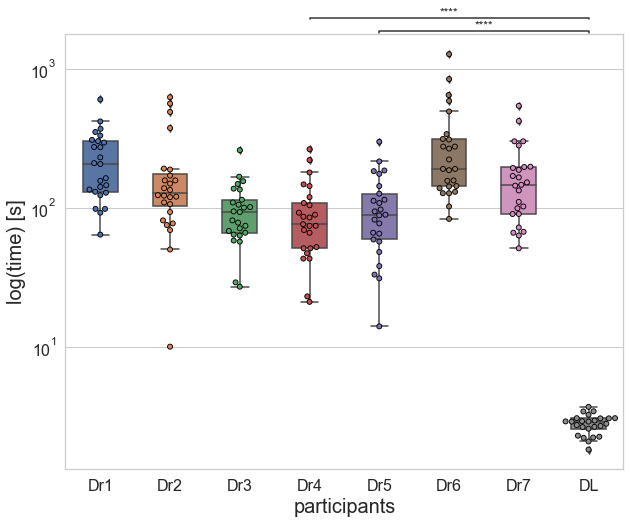

In [9]:
##visualizing time needed for segmentations

plt.figure(figsize=(10,8))

sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel='participants', ylabel='log(time) [s]', fontsize=20)
ax = sns.boxplot(data=df_tr, width=0.5,)
ax.set_yscale("log")
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
p = sns.swarmplot(data=df_tr, size=5, edgecolor="black", linewidth=.9)

an = add_stat_annotation(ax, data=df_tr, box_pairs=[("Dr4", "DL"), ("Dr5", "DL")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)


In [5]:
#Calculate averaged time for doctors
only_doctors_t = df_tr.drop(columns=['DL'])
print('Averaged Doctors contouring time: Mean: %s sec. std: %s sec.'%(np.mean(only_doctors_t.dropna().values), 
                                                                      np.std(only_doctors_t.dropna().values)))


Averaged Doctors contouring time: Mean: 172.1904761904762 sec. std: 158.98828020527296 sec.


In [6]:
#Calculate averaged time for dl
print('Averaged DL contouring time: Mean: %s sec. std: %s sec.'%(np.mean(df_tr['DL']),np.std(df_tr['DL'])))


Averaged DL contouring time: Mean: 2.7788 sec. std: 0.44352515148523425 sec.


## Part 2: Reproducibility study (Intra-/Inter-variability assesment)

In [7]:
#load the scores
scores_df = pd.read_excel('./data/intra-variability_dsc.xlsx')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dr5 v.s. DL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.946e-10 U_stat=0.000e+00
Dr4 v.s. DL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.946e-10 U_stat=0.000e+00


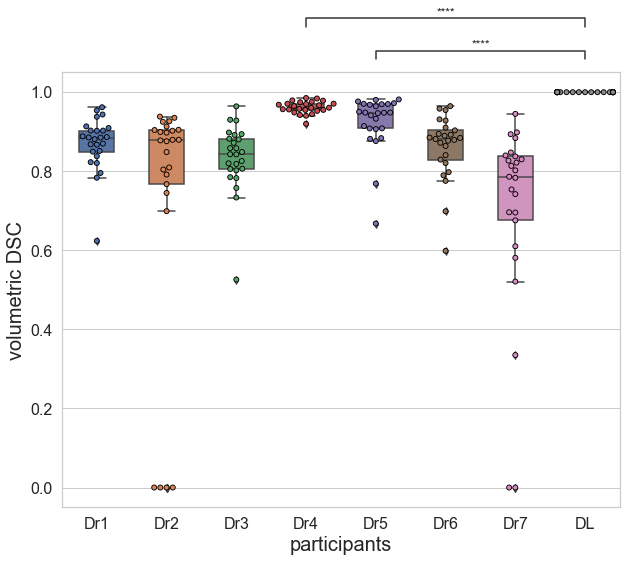

In [10]:
#Visualize
plt.figure(figsize=(10,8))

sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel='participants', ylabel='volumetric DSC', fontsize=20)
ax = sns.boxplot(data=scores_df, width=0.5,)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
sns.swarmplot(data=scores_df, size=5, edgecolor="black", linewidth=.9)

an = add_stat_annotation(ax, data=scores_df, box_pairs=[("Dr4", "DL"), ("Dr5", "DL")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)


In [9]:
#Calculate averaged DSC for doctor's intra variability
only_doctors_dsc = scores_df.drop(columns=['DL'])
print('Averaged DICE for intra-variability for manual segmentations: %s iqr: %s '%(np.median(only_doctors_dsc.values),scipy.stats.iqr(only_doctors_dsc.values)))


Averaged DICE for intra-variability for manual segmentations: 0.8851744186046512 iqr: 0.12374912584587427 


In [10]:
#Load scores
scores_df_hausd = pd.read_excel('./data/intra-variability_hausdorf.xlsx')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dr5 v.s. DL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.791e-10 U_stat=6.250e+02
Dr4 v.s. DL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.551e-10 U_stat=6.250e+02


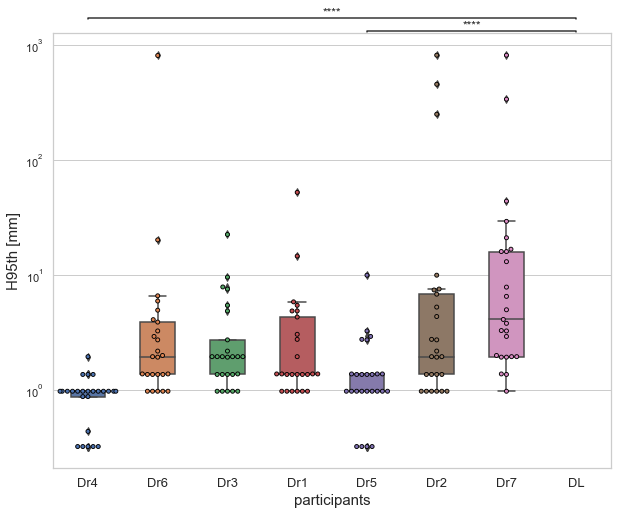

In [11]:
#Visualize
plt.figure(figsize=(10,8))

sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel='participants', ylabel='H95th [mm]', fontsize=15)
ax = sns.boxplot(data=scores_df_hausd, width=0.5)
ax.set_yscale("log")
plt.setp(ax.get_xticklabels(), fontsize=13)
sns.swarmplot(data=scores_df_hausd, size=4, edgecolor="black", linewidth=.9)

an = add_stat_annotation(ax, data=scores_df_hausd, box_pairs=[("Dr4", "DL"), ("Dr5", "DL")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)


In [12]:
only_doctors_h = scores_df_hausd.drop(columns=['DL'])
print('Averaged H95th for intra-variability: ',np.median(only_doctors_h.values),'[mm]')


Averaged H95th for intra-variability:  1.381067224898195 [mm]


In [13]:
#Load scores
scores_df_jacc = pd.read_excel('./data/intra-variability_jacc.xlsx')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dr5 v.s. DL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.946e-10 U_stat=0.000e+00
Dr4 v.s. DL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.946e-10 U_stat=0.000e+00


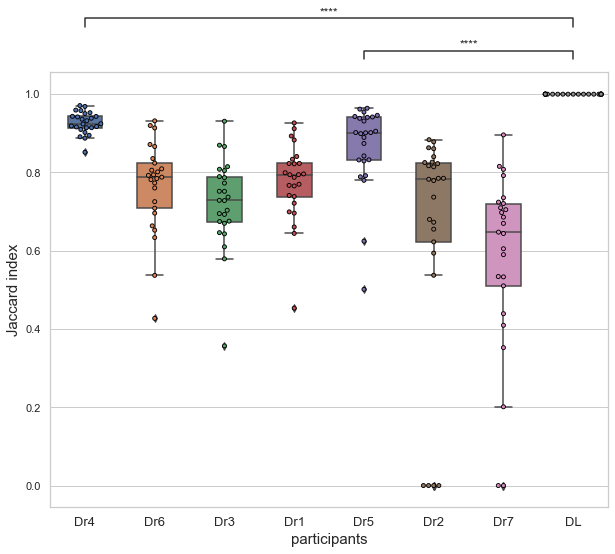

In [14]:
#Visualize
plt.figure(figsize=(10,8))

sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel='participants', ylabel='Jaccard index', fontsize=15)
ax = sns.boxplot(data=scores_df_jacc, width=0.5)
a =plt.setp(ax.get_xticklabels(), fontsize=13)
pl = sns.swarmplot(data=scores_df_jacc, size=4, edgecolor="black", linewidth=.9)

an = add_stat_annotation(ax, data=scores_df_jacc, box_pairs=[("Dr4", "DL"), ("Dr5", "DL")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)


In [15]:
only_doctors_j = scores_df_jacc.drop(columns=['DL'])
print('Averaged Jacc for intra-variability:%s ,iqr: %s'%(np.median(only_doctors_j.values),scipy.stats.iqr(only_doctors_j.values)))


Averaged Jacc for intra-variability:0.7940026075619296 ,iqr: 0.1983082637116249


### Inter-variability assesment

In [16]:
#load data
scores_df = pd.read_excel('./data/inter-variability_dsc.xlsx')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dr4 v.s. Dr6: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.842e-01 U_stat=1.392e+04
Dr6 v.s. Dr7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.705e-04 U_stat=1.903e+04


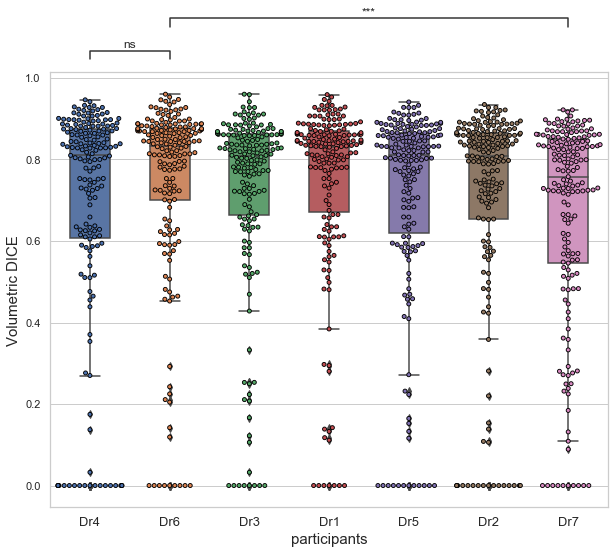

In [17]:
#visualize
plt.figure(figsize=(10,8))

sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel='participants', ylabel='Volumetric DICE', fontsize=15)
ax = sns.boxplot(data=scores_df, width=0.5,)
a =plt.setp(ax.get_xticklabels(), fontsize=13)
pl = sns.swarmplot(data=scores_df, size=4, edgecolor="black", linewidth=.9)

an = add_stat_annotation(ax, data=scores_df, box_pairs=[("Dr4", "Dr6"), ("Dr7", "Dr6")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)


In [18]:
print('Averaged DICE for intra- variability: ',np.median(scores_df.values),scipy.stats.iqr(scores_df.values))


Averaged DICE for intra- variability:  0.8111702127659575 0.23902671722978186


## Inter-variability assesment of the manual &proposed method contours on the vaidation dataset #8

In [12]:
#load data
plot_data = pd.read_excel(r"./data/dataset8_multi_doctor_stats.xlsx")
plot_data = plot_data.drop('Unnamed: 0',axis=1)
plot_data = plot_data.to_dict('list')

formatted_scores = pd.read_excel(r"./data/dataset8_multi_doctor_stats_formatted.xlsx")
formatted_scores = formatted_scores.drop('Unnamed: 0',axis=1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


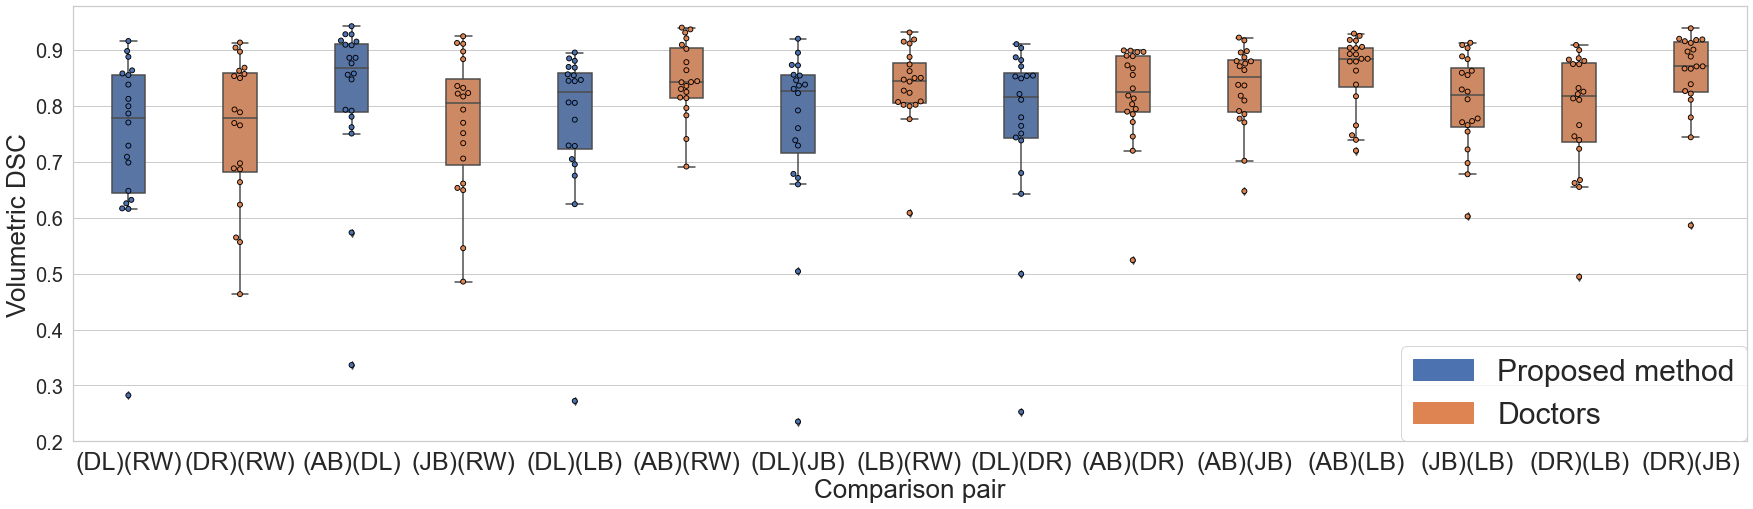

In [15]:
plt.figure(figsize=(30,8))
# sort keys and values together

sorted_keys, sorted_vals = zip(*sorted(plot_data.items(), key=op.itemgetter(1)))
#set color for DL
my_pal = {i: sns.color_palette()[0] if re.search('DL',key) else sns.color_palette()[1] for i,key in enumerate(sorted_keys)}
sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel='Comparison pair', ylabel='Volumetric DSC', fontsize=26)
ax = sns.boxplot(data=sorted_vals, width=.3,palette=my_pal)
sns.swarmplot(data=sorted_vals, size=5, edgecolor="black", linewidth=.9,palette=my_pal)

Dl_patch = mpatches.Patch(color=sns.color_palette()[0], label='Proposed method')
Dr_patch = mpatches.Patch(color=sns.color_palette()[1], label='Doctors')
ax.legend(handles=[Dl_patch,Dr_patch],borderaxespad=0.,loc=4, fontsize=30)


# category labels
plt.xticks(plt.xticks()[0], sorted_keys,fontsize=25)
plt.yticks(fontsize=20)
#plt.show()
plt.savefig('fig6.eps', format='eps')


In [21]:
##print scores
Dl_avg = np.median(formatted_scores.Score.values[np.where(formatted_scores.Class =='DL')])
Dl_iqr = scipy.stats.iqr(formatted_scores.Score.values[np.where(formatted_scores.Class =='DL')])
print('Average DSC score of proposed method across doctors is:  %s, IQR: %s'%(Dl_avg,Dl_iqr))


Average DSC score of proposed method across doctors is:  0.8223286690886631, IQR: 0.14132861189424795


In [22]:
##print scores
Dr_avg = np.median(formatted_scores.Score.values[np.where(formatted_scores.Class =='DR')])
Dr_iqr = scipy.stats.iqr(formatted_scores.Score.values[np.where(formatted_scores.Class =='DR')])
print('Average DSC inter-variability score for doctors is:  %s, IQR: %s'%(Dr_avg,Dr_iqr))


Average DSC inter-variability score for doctors is:  0.8364689510724808, IQR: 0.11593459879764556
